In [10]:
from dolfin import *
from rbnics import *

In [11]:
import sys
import importlib
import inverse_id
importlib.reload(inverse_id)
import shutil

shutil.rmtree("cache", ignore_errors=True)
shutil.rmtree("RBniCS_cache", ignore_errors=True)

refinement level 0, number of nodes = 81
Solving linear variational problem.
refinement level 1, number of nodes = 289
Solving linear variational problem.
refinement level 2, number of nodes = 1089
Solving linear variational problem.
refinement level 3, number of nodes = 4225
Solving linear variational problem.
refinement level 4, number of nodes = 16641
Solving linear variational problem.
Level 0: h=1.768e-01,  L2=1.840e-04
Level 1: h=8.839e-02,  L2=2.907e-05
Level 2: h=4.419e-02,  L2=4.165e-06
Level 3: h=2.210e-02,  L2=5.780e-07


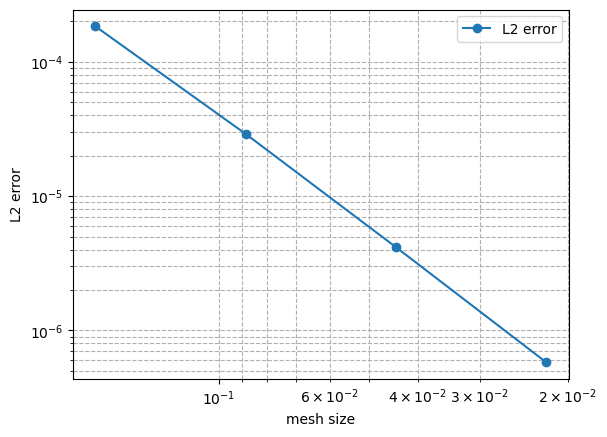

In [12]:

# re-define domains for new mesh
def create_domain(mesh):
    subdomains = MeshFunction("size_t", mesh, mesh.topology().dim(), 1)
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)

    class Bottom(SubDomain):
        def inside(self, x, on_boundary):
            return on_boundary and near(x[1], 0)
    bottom = Bottom()
    bottom.mark(boundaries, 1)
    boundaries.array()[boundaries.array()==0] = 2

    return subdomains, boundaries


# define PDE and run FE simulation
def fe_solve(mesh, subdomains, boundaries, mu):
    Biot, q = mu

    V = FunctionSpace(mesh, "Lagrange", 2)
    u = TrialFunction(V)
    v = TestFunction(V)

    dx = Measure("dx", domain=mesh, subdomain_data=subdomains)
    ds = Measure("ds", domain=mesh, subdomain_data=boundaries)

    a = inner(grad(u), grad(v)) * dx(1) \
        + Biot * u * v * ds(2)

    L = q * v * ds(1)

    u_sol = Function(V)
    solve(a == L, u_sol)
    return u_sol


# run FE simulation
mu = (1.5, 5.0)
meshes = []
solutions = []
mesh = UnitSquareMesh(8, 8) # generate mesh
subd, bnd = create_domain(mesh)
n_levels = 5
for level in range(n_levels): # refine mesh and run FE simulation
    print(f"refinement level {level}, number of nodes = {mesh.num_vertices()}")
    u = fe_solve(mesh, subd, bnd, mu)
    meshes.append(mesh)
    solutions.append(u)

    if level < n_levels - 1:
        mesh = refine(mesh)
        subd, bnd = create_domain(mesh)


# compute L2 error
u_ref = solutions[-1] # set reference solution (from finest mesh)
Vref = u_ref.function_space()
mesh_ref = Vref.mesh()
dx_ref = Measure("dx", domain=mesh_ref)
L2_errors = []
h_values = []
for i, u in enumerate(solutions[:-1]):
    mesh_i = meshes[i]
    h = mesh_i.hmax() # mesh size
    h_values.append(h)
    u_int = interpolate(u, Vref) # interpolate coarse solution to finite space

    diff = Function(Vref)
    diff.vector()[:] = u_int.vector() - u_ref.vector()
    L2_err = np.sqrt(assemble(inner(diff, diff) * dx_ref))
    L2_errors.append(L2_err)
    print(f"Level {i}: h={h:.3e},  L2={L2_err:.3e}")


# plot convergence
plt.loglog(h_values, L2_errors, "-o", label="L2 error")
plt.gca().invert_xaxis()
plt.xlabel("mesh size")
plt.ylabel("L2 error")
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

